In [1]:
import numpy as np
import scipy, time
import warnings
import matplotlib.pyplot as plt
from random import random
from collections import Counter
from scipy.interpolate import interp1d
from scipy import stats, integrate

warnings.filterwarnings('ignore')

#returns the step function value at each increment of the CDF
def cumcount_reduced(arr):
    '''Cumulative count of a array'''
    sorted_arr = np.array(sorted(arr))
    counts = np.zeros(len(arr))
    
    rolling_count = 0
    for idx, elem in enumerate(sorted_arr):
        rolling_count += 1
        counts[idx] = rolling_count

    counts /= len(counts)
    counts -= (1 / (2 * len(counts)))

    return (sorted_arr, counts)

#takes two datasets to estimate the relative entropy between their PDFs
#we use eps=10^-11, but it could be defined as < the minimal interval between data points
def KLD_PerezCruz(P, Q, eps=1e-11):
    '''KL divergence calculation'''
    P = sorted(P)
    Q = sorted(Q)
    
    P_positions, P_counts = cumcount_reduced(P)
    Q_positions, Q_counts = cumcount_reduced(Q)
    
    #definition of x_0 and x_{n+1}
    x_0 = np.min([P_positions[0], Q_positions[0]]) - 1
    P_positions = np.insert(P_positions, 0, [x_0])
    P_counts = np.insert(P_counts, 0, [0])
    Q_positions = np.insert(Q_positions, 0, [x_0])
    Q_counts = np.insert(Q_counts, 0, [0])
    
    x_np1 = np.max([P_positions[-1], Q_positions[-1]]) + 1
    P_positions = np.append(P_positions, [x_np1])
    P_counts = np.append(P_counts, [1])
    Q_positions = np.append(Q_positions, [x_np1])
    Q_counts = np.append(Q_counts, [1])
    
    f_P = interp1d(P_positions, P_counts)
    f_Q = interp1d(Q_positions, Q_counts) 
    
    X = P_positions[1:-2]
    values = (f_P(X) - f_P(X - eps)) / (f_Q(X) - f_Q(X - eps))
    filt = ((values != 0.) & ~(np.isinf(values)) & ~(np.isnan(values)))
    values_filter = values[filt]
    out = (np.sum(np.log(values_filter)) / len(values_filter)) - 1.

    return out

Importing the data from the timeseries of two stochastic processes.
First column is the time, while second and third columns are the two stochastic processes (in a.u.).

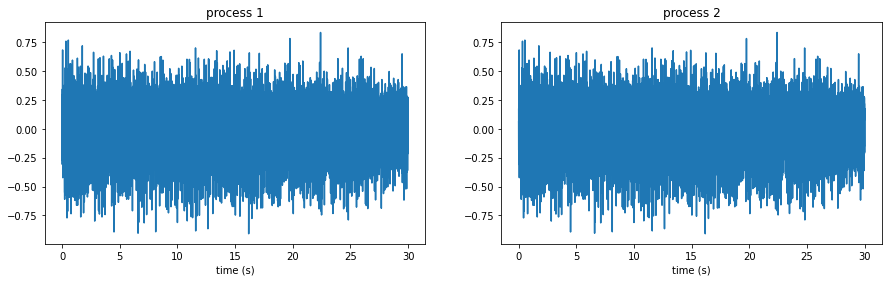

In [2]:
data = np.genfromtxt("testdata.txt")
time = [x[0] for x in data]
proc1 = [x[1] for x in data]
proc2 = [x[2] for x in data]

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,15))

ax1.set(aspect=10)
ax1.set_title('process 1')
ax1.set_xlabel('time (s)')
ax1.plot(time, proc1)

ax2.set(aspect=10)
ax2.set_title('process 2')
ax2.set_xlabel('time (s)')
ax2.plot(time, proc1)

plt.show()

Probability distribution of both processes

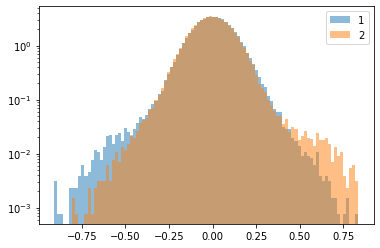

In [3]:
hist1 = plt.hist(proc1, 100, alpha=0.5, label='1', density=True)
hist2 = plt.hist(proc2, hist1[1], alpha=0.5, label='2', density=True)
plt.yscale('log')
plt.legend(loc='upper right')
plt.show()

Kullback-Leibler divergence between both data

In [4]:
kld_value = KLD_PerezCruz(proc1, proc2)
dt = (time[1] - time[0])
kld_rate = kld_value/dt
print(f"KLD = {kld_value:.4f}")
print(f"KLD per unit of time = {kld_rate:.2f} s^-1")

KLD = 0.0026
KLD per unit of time = 6.56 s^-1


Comparison with the standard method: plugging the estimated probability distribution onto the definition
$D_\text{KL}(P\vert\vert Q) = \sum_X P(X) \log P(X)/Q(X)$

In [5]:
bin_size = hist1[1][1] - hist1[1][0]
p = hist1[0]*bin_size
q = hist2[0]*bin_size

kld_std = np.sum(np.where((p != 0) & (q != 0), p * np.log( p / q), 0))

print(f"standard KLD = {kld_std:.4f}")
print(f"standard KLD per unit of time = {(kld_std/dt):.2f} s^-1")

standard KLD = 0.0051
standard KLD per unit of time = 12.81 s^-1


Convergence of the estimators, first using Pérez-Cruz's unbiased algorithm and later the biased standard method

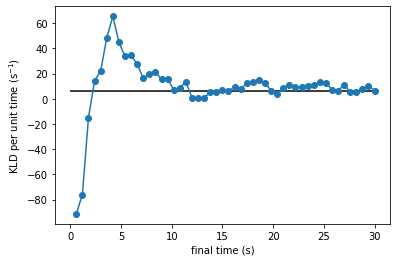

Wall time: 6.97 s


In [6]:
%%time
final_iteration = np.linspace(0,len(time), 51, dtype = int)[1:]
final_times = [time[x-1] for x in final_iteration]
kld_vec = []
for fit in final_iteration:
    proc1_fit = [x[1] for x in data[:fit]]
    proc2_fit = [x[2] for x in data[:fit]]
    kld_fit = KLD_PerezCruz(proc1_fit, proc2_fit)/dt
    kld_vec.append(kld_fit)
    
plt.plot(final_times, kld_vec, 'o-')
plt.xlabel(r'final time (s)')
plt.ylabel(r'KLD per unit time (s$^{-1}$)')
plt.hlines(kld_value/dt, time[0], time[-1], color='black', alpha=1, zorder=-1)
plt.show()

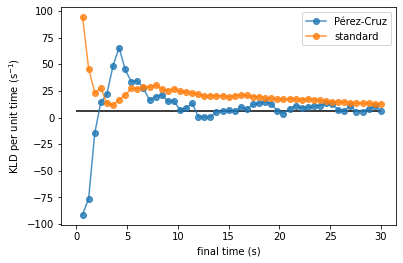

Wall time: 2.22 s


In [7]:
%%time
kld_std_vec = []
for fit in final_iteration:
    proc1_fit = [x[1] for x in data[:fit]]
    proc2_fit = [x[2] for x in data[:fit]]
    hist1 = np.histogram(proc1_fit, 100, density=True)
    hist2 = np.histogram(proc2_fit, hist1[1], density=True)
    p = hist1[0]*bin_size
    q = hist2[0]*bin_size
    kld_std = np.sum(np.where((p != 0) & (q != 0), p * np.log( p / q), 0))/dt
    kld_std_vec.append(kld_std)

plt.plot(final_times, kld_vec, 'o-', label='Pérez-Cruz', alpha=0.8)
plt.plot(final_times, kld_std_vec, 'o-', label='standard', alpha=0.8)
plt.xlabel(r'final time (s)')
plt.ylabel(r'KLD per unit time (s$^{-1}$)')
plt.hlines(kld_value/dt, time[0], time[-1], color='black', alpha=1, zorder=-1)
plt.legend(loc='upper right')
plt.show()